# Improving Person Re-identification by Attribute and Identify Learning

# Dataset: Market-1501

Contains:
- 19,732 images for 751 identities $\rightarrow$ training set
- 13,328 images for 750 identities $\rightarrow$ test set
- 27 attributes for each image

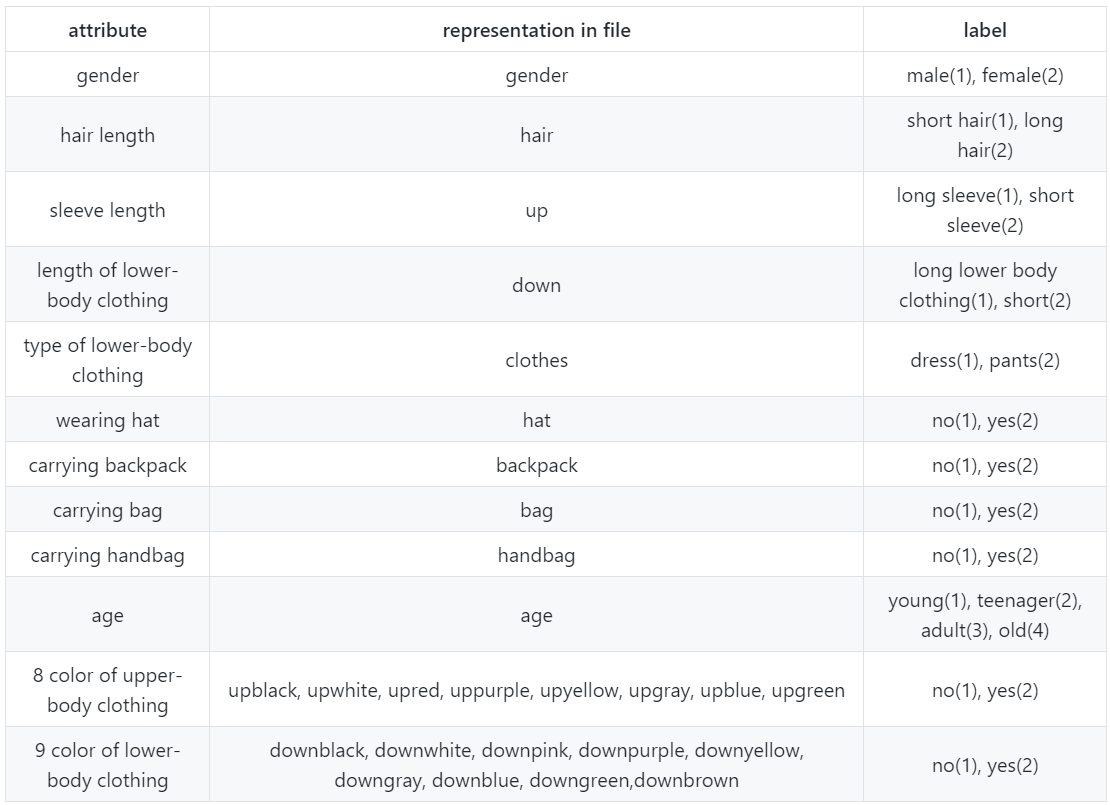

# Re-identification algorithm implementation

### Problématic: Person re-identification

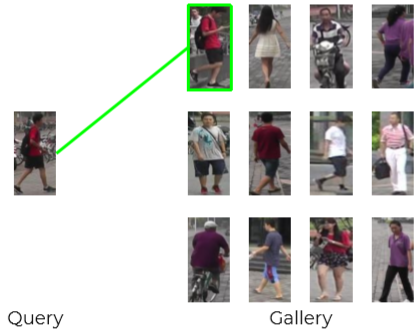

### Objective

Using tensorﬂow.keras implement the algorithm of re-identiﬁcation described in the article _Lin et al. - Improving Person Re-identiﬁcation by Attribute and Identity Learning - 2019_.

1. Using a pre-trained resnet50 on imagenet, implement the algorithm of classiﬁcation by Attribute.

2. Implement a first algorithm of re-identiﬁcation by combining the classiﬁcation of attributes with an additional fully-connected layer for the identiﬁcation.

3. Increase the dataset data during training according to the protocol described on page 7 of the article ("Randomly cropping and horizontal ﬂipping are applied on the input images during training.").

4. Implement a system to compare 2 feature vectors (Euclidean distance is a good starting point). 

5. **Bonus**: Implement the attribute reweighting module "Attributes Re-Weighting".

**Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Dense, BatchNormalization, Dropout, Concatenate, Multiply
from keras.metrics import binary_accuracy, categorical_accuracy, sparse_categorical_accuracy
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.preprocessing import image
from keras.optimizers import SGD
from keras import Input, Model 

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import cv2
import os

Using TensorFlow backend.


<hr style="background-color: rgb(0,0,0);height: 1.0px;"/>

## I - Data Preprocessing

**Attributes**

We load our attributes into two dataframes. We can notice that we have different and random indexes in our train and test dataframes.

In [2]:
def attribute_preprocessing():
    # Define attributes
    attribute: np.ndarray = np.array([
    'backpack', 'bag', 'handbag', 'downblack', 'downblue',
    'downbrown', 'downgray', 'downgreen', 'downpink', 'downpurple',
    'downwhite', 'downyellow', 'upblack', 'upblue', 'upgreen', 'upgray',
    'uppurple', 'upred', 'upwhite', 'upyellow', 'clothes', 'down', 'up',
    'hair', 'hat', 'gender'], dtype=object)
        
    # Open json file with attributes
    with open('market_attribute.json') as file:
        data = json.load(file)    

    # Select our train and test data
    train = data['train']
    test = data['test']

    # Create dataframe with train and test data
    train_att = pd.DataFrame(
        data=list(zip(train['age'], train['backpack'], train['bag'], train['handbag'], train['downblack'], 
                      train['downblue'], train['downbrown'], train['downgray'], train['downgreen'], 
                      train['downpink'], train['downpurple'], train['downwhite'], train['downyellow'], 
                      train['upblack'], train['upblue'], train['upgreen'], train['upgray'], train['uppurple'], 
                      train['upred'], train['upwhite'], train['upyellow'], train['clothes'], train['down'], 
                      train['up'], train['hair'], train['hat'], train['gender'], train['image_index'])), 
        columns=train.keys())

    test_att = pd.DataFrame(
        data=list(zip(test['age'], test['backpack'], test['bag'], test['handbag'], test['downblack'], 
                      test['downblue'], test['downbrown'], test['downgray'], test['downgreen'], test['downpink'], 
                      test['downpurple'], test['downwhite'], test['downyellow'], test['upblack'], test['upblue'], 
                      test['upgreen'], test['upgray'], test['uppurple'], test['upred'], test['upwhite'], 
                      test['upyellow'], test['clothes'], test['down'], test['up'], test['hair'], test['hat'], 
                      test['gender'], test['image_index'])), columns=test.keys())

    train_att.age = train_att.age < 2
    train_att.age = train_att.age.astype(int)
    train_att[attribute] -= 1

    test_att.age = test_att.age < 2
    test_att[attribute] -= 1
    test_att.age = test_att.age.astype(int)
        
    print('Shape df_train: ', train_att.shape)
    print('Shape df_test: ', test_att.shape)
    
    return train_att, test_att, train['image_index']

**Images**

We load our images and create two files in our `Market-1501` folder:
- `Market-1501/train` that contains 50% of our images for train purpose.
- `Market-1501/test` that contains 50% of our images for test purpose.

In [3]:
def image_preprocessing(train_df, test_df):
    trainImg_files = os.listdir('Market-1501/train')
    testImg_files = os.listdir('Market-1501/test')
    img = []
    train_img, test_img = [], []
    train_file, test_file = [], []
    train_f, test_f = [], []
    
    for path in trainImg_files:
        img = cv2.imread(path)
        imgpath = os.path.join('Market-1501/train', path)
        img = cv2.imread(imgpath)
        train_file.append(imgpath)
        train_f.append(path[0:4])
        train_img.append(img)

    for path in testImg_files:
        img = cv2.imread(path)
        imgpath = os.path.join('Market-1501/test', path)
        img = cv2.imread(imgpath)
        test_file.append(imgpath)
        test_f.append(path[0:4])
        test_img.append(img)
        
    trainImg_df = pd.DataFrame(data=list(zip(train_img, train_file, train_f)), 
                               columns=['images', 'path', 'image_index'])
    trainImg_df['image_index'] = trainImg_df['image_index'].astype(int)
    train_df['image_index'] = train_df['image_index'].astype(int)
    trainImg_df = trainImg_df.merge(train_df, on='image_index', how='left')
    
    testImg_df = pd.DataFrame(data=list(zip(test_img, test_file, test_f)), 
                              columns=['images', 'path', 'image_index'])
    testImg_df['image_index'] = testImg_df['image_index'].astype(int)
    test_df['image_index'] = test_df['image_index'].astype(int)
    testImg_df = testImg_df.merge(test_df, on='image_index', how='left')
        
    print('Length train_img: ', len(train_img))
    print('Length test_img: ', len(test_img))
    print('Shape trainImg_df: ', trainImg_df.shape)
    
    return img, train_img, test_img, train_file, test_file, trainImg_df, testImg_df

<hr style="background-color: rgb(0,0,0);height: 1.0px;"/>

## II - ResNet50 Model

We build our model based on the details provided in the article.

Model features:
    - pool5 layer
    - 512-dim fully connected layer later concatenated with the 27-dim attribute prediction score
    - Batch Normalization
    - Dropout layer (0.5 drop rate)
    - Learning Rate initialized at 0.01 then modified to 0.001 for the last 20 epochs


### Models

In [4]:
model_path = "../model/"

def get_base_model(n_id, n_att):
    input_tensor = Input(shape=(128, 64, 3))
    
    # Create the pre-trained model with ImageNet ResNet-50 model without top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 64, 3), pooling="avg")(input_tensor)
    
    # Attribute Layer, Weighting and Re-Weighting
    attribute_layer = Dense(n_att, activation="sigmoid", name="attribute")(base_model)
    attribute_weight = Dense(n_att, activation="sigmoid")(attribute_layer)
    attribute_reweight = Multiply()([attribute_layer, attribute_weight])
    
    # ID Layer
        # Fully Connected layer
    dense_layer = Dense(512, activation='relu')(base_model)
        # Batch Normalization
    batch_layer = BatchNormalization()(dense_layer)
        # Dropout
    dropout_layer = Dropout(rate=0.5)(batch_layer)
        # 512-dim fully connected layer concatenated with the 27-dim attribute prediction score
    id_layer = Concatenate(axis=-1, name='image_feature')([attribute_reweight, dropout_layer])

    trainId_layer = Dense(n_id, activation="softmax", name="identity")(id_layer)

    # Final Model
        # Attribute model using the attribute_layer
    attribute_model = Model(input_tensor, attribute_layer)
        # Id model using the id_layer
    id_model = Model(input_tensor, id_layer)
        # Train model with the attribute_layer and the trainId_layer
    train_model = Model(input_tensor, [attribute_layer, trainId_layer])
    
    return (attribute_model, train_model, id_model)

### Attributes Model

Model.

In [5]:
model_attribute, _, _ = get_base_model(n_id=751, n_att=27)
model_attribute.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
model_attribute.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 64, 3)        0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
attribute (Dense)            (None, 27)                55323     
Total params: 23,643,035
Trainable params: 23,589,915
Non-trainable params: 53,120
_________________________________________________________________


History.

In [6]:
# Preprocess attributes and images
train_att, test_att, _ = attribute_preprocessing()
_, train_img, test_img, _, _, _, _ = image_preprocessing(train_att, test_att)

train_att = train_att.drop(['image_index'], axis=1)
test_att = test_att.drop(['image_index'], axis=1)

# Chosen features
batch_size =32 
epochs = 5
sample = slice(0, 300)

# Attribute model history
hist = model_attribute.fit(preprocess_input(np.array(train_img[sample])), train_att.values[0:300], epochs=epochs, batch_size=batch_size, validation_split=0.2)

Shape df_train:  (751, 28)
Shape df_test:  (750, 28)
Length train_img:  12567
Length test_img:  12692
Shape trainImg_df:  (12567, 30)
Train on 240 samples, validate on 60 samples
Epoch 1/5
240/240 [==============================] - 12s 49ms/step - loss: 0.5246 - accuracy: 0.7573 - val_loss: 0.6333 - val_accuracy: 0.8457
Epoch 2/5
240/240 [==============================] - 1s 4ms/step - loss: 0.2853 - accuracy: 0.8832 - val_loss: 0.6059 - val_accuracy: 0.8086
Epoch 3/5
240/240 [==============================] - 1s 4ms/step - loss: 0.1500 - accuracy: 0.9457 - val_loss: 0.5516 - val_accuracy: 0.7907
Epoch 4/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0693 - accuracy: 0.9819 - val_loss: 0.4597 - val_accuracy: 0.8142
Epoch 5/5
240/240 [==============================] - 1s 4ms/step - loss: 0.0267 - accuracy: 0.9972 - val_loss: 0.5025 - val_accuracy: 0.8179


Plot.

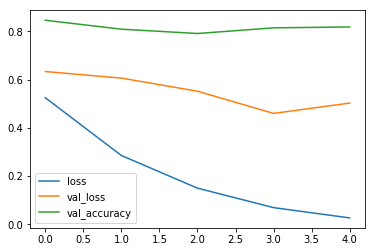

In [7]:
plt.plot(range(epochs), hist.history["loss"], label="loss")
plt.plot(range(epochs), hist.history["val_loss"], label="val_loss")
plt.plot(range(epochs), hist.history["val_accuracy"], label="val_accuracy")
plt.legend()

Prediction.

In [8]:
pred = model_attribute.predict(preprocess_input(np.array(train_img[sample])))
print(pred)

[[1.1240542e-02 1.8132061e-02 6.8576699e-01 ... 6.5579683e-02
  7.4475408e-03 1.3607395e-01]
 [1.2461275e-02 1.2638032e-02 9.4735587e-01 ... 6.9245577e-02
  5.5327117e-03 3.7205130e-02]
 [2.1090031e-02 3.6754906e-03 9.6064794e-01 ... 4.4804624e-01
  1.4154345e-02 7.6204407e-01]
 ...
 [1.9994378e-04 4.7879517e-03 7.5695467e-01 ... 7.3656738e-03
  2.4693608e-03 1.8680137e-01]
 [1.0148257e-02 8.2766414e-03 9.2896158e-01 ... 6.3965499e-02
  2.3137331e-03 1.4442357e-01]
 [2.0716280e-02 4.0191820e-01 5.0041711e-01 ... 1.6007468e-01
  4.7584593e-02 3.3719921e-01]]


Evaluation.

In [9]:
eval = model_attribute.evaluate(preprocess_input(np.array(test_img[sample])), test_att.values[0:300], batch_size=1, verbose=0)
print(eval)

[0.5073293914397558, 0.8134562373161316]


### Identities Model

In [10]:
# Preprocess attributes and images
train_df, test_df, img_attId = attribute_preprocessing()
img, train_img, test_img, train_file, test_file, trainImg_df, testImg_df = image_preprocessing(train_df, test_df)

train_img = train_img
trainFile = train_file

encode_id = dict()
train_id = np.zeros(len(trainFile), dtype=int)
x = 0
for y, file in enumerate(trainFile):
    if file[:4] not in encode_id:
        encode_id[file[:4]] = x
        x += 1
    train_id[y] = encode_id[file[:4]]
    
n_id = len(encode_id)

Shape df_train:  (751, 28)
Shape df_test:  (750, 28)
Length train_img:  12567
Length test_img:  12692
Shape trainImg_df:  (12567, 30)


Model.

In [11]:
_, model_train, model_id = get_base_model(n_id=1501, n_att=27)

print("---Train model summary---\n")
model_train.summary()
print("\n\n")
print("---Id model summary---\n")
model_id.summary()

---Train model summary---

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 64, 3)   0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    input_3[0][0]                    
__________________________________________________________________________________________________
attribute (Dense)               (None, 27)           55323       resnet50[1][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          1049088     resnet50[1][0]                   
_________________________________________________________________

Metrics.

In [12]:
attribute: np.ndarray = np.array([
    'age', 'backpack', 'bag', 'clothes', 'down', 'downblack',
    'downblue', 'downbrown', 'downgray', 'downgreen', 'downpink',
    'downpurple', 'downwhite', 'downyellow', 'gender', 'hair',
    'handbag', 'hat', 'up', 'upblack', 'upblue', 'upgray', 'upgreen',
    'uppurple', 'upred', 'upwhite', 'upyellow'], dtype=object)
    
down_color = slice(5, 14)
up_color = slice(19, 27)
bin_1 = slice(0, 5)
bin_2 = slice(14, 19)

In [13]:
# Attribute accuracy
def attribute_accuracy(y_true, y_pred):
    acc = binary_accuracy(y_true[:, bin_1], y_pred[:, bin_1]) * 0.5
    acc += binary_accuracy(y_true[:, bin_2], y_pred[:, bin_2]) * 0.5
    # Color for top clothes
    acc_colorTop = categorical_accuracy(y_true[:, up_color], y_pred[:, up_color])
    # Color for down clothes
    acc_colorDown = categorical_accuracy(y_true[:, down_color], y_pred[:, down_color])
    
    return acc * 9/11 + acc_colorDown * 1/11 + acc_colorTop * 1/11

Loss.

In [14]:
# lambda defined in the paper
lamb = 0.9

# Compile model_train
model_train.compile(optimizer=SGD(), loss=["binary_crossentropy", "sparse_categorical_crossentropy"], 
                    metrics={"attribute":[attribute_accuracy], "identity":[sparse_categorical_accuracy]})

# Attribute loss
def attribute_loss(y_true, y_pred):
    return lamb * attribute_accuracy(y_true, y_pred)

# Id loss
def identity_loss(y_true, y_pred):
    return (1 - lamb) * sparse_categorical_accuracy(y_true, y_pred)

History.

In [15]:
# Chosen features
epochs = 60
batch_size = 32
sample = slice(0, 2)

# Callback
# Learning Rate initialized at 0.01 then modified to 0.001 for the last 20 epochs
callback = [EarlyStopping(patience=10, monitor = 'val_loss'),
            ModelCheckpoint(f"weights/model-weights-{{epoch:02d}}.h5", save_weights_only=True),
            LearningRateScheduler(lambda epoch:0.01 if epoch < 41 else 0.001)]

# Id model history
hist = model_train.fit(x=preprocess_input(np.array(train_img[:])), 
                       y=[np.array(trainImg_df[attribute].values[:]), 
                        np.array(trainImg_df.image_index[:])], epochs=60, batch_size=32, 
                       callbacks=callback, validation_split=0.2)

Train on 10053 samples, validate on 2514 samples
Epoch 1/60
10053/10053 [==============================] - 43s 4ms/step - loss: 7.6731 - attribute_loss: 0.4254 - identity_loss: 7.2484 - attribute_attribute_accuracy: 0.6743 - identity_sparse_categorical_accuracy: 0.0173 - val_loss: 6.6213 - val_attribute_loss: 0.3523 - val_identity_loss: 6.2685 - val_attribute_attribute_accuracy: 0.7353 - val_identity_sparse_categorical_accuracy: 0.0720
Epoch 2/60
10053/10053 [==============================] - 34s 3ms/step - loss: 5.7301 - attribute_loss: 0.2978 - identity_loss: 5.4352 - attribute_attribute_accuracy: 0.7722 - identity_sparse_categorical_accuracy: 0.1740 - val_loss: 5.0026 - val_attribute_loss: 0.2778 - val_identity_loss: 4.7249 - val_attribute_attribute_accuracy: 0.7895 - val_identity_sparse_categorical_accuracy: 0.2526
Epoch 3/60
10053/10053 [==============================] - 34s 3ms/step - loss: 4.1168 - attribute_loss: 0.2528 - identity_loss: 3.8665 - attribute_attribute_accuracy: 0.

Epoch 22/60
10053/10053 [==============================] - 34s 3ms/step - loss: 0.1064 - attribute_loss: 0.0747 - identity_loss: 0.0338 - attribute_attribute_accuracy: 0.9577 - identity_sparse_categorical_accuracy: 1.0000 - val_loss: 1.1144 - val_attribute_loss: 0.1238 - val_identity_loss: 0.9895 - val_attribute_attribute_accuracy: 0.9119 - val_identity_sparse_categorical_accuracy: 0.8123
Epoch 23/60
10053/10053 [==============================] - 34s 3ms/step - loss: 0.1012 - attribute_loss: 0.0711 - identity_loss: 0.0317 - attribute_attribute_accuracy: 0.9599 - identity_sparse_categorical_accuracy: 1.0000 - val_loss: 1.1189 - val_attribute_loss: 0.1220 - val_identity_loss: 0.9955 - val_attribute_attribute_accuracy: 0.9135 - val_identity_sparse_categorical_accuracy: 0.8115
Epoch 24/60
10053/10053 [==============================] - 34s 3ms/step - loss: 0.0972 - attribute_loss: 0.0676 - identity_loss: 0.0323 - attribute_attribute_accuracy: 0.9627 - identity_sparse_categorical_accuracy: 1

Epoch 43/60
10053/10053 [==============================] - 34s 3ms/step - loss: 0.0519 - attribute_loss: 0.0326 - identity_loss: 0.0204 - attribute_attribute_accuracy: 0.9824 - identity_sparse_categorical_accuracy: 0.9999 - val_loss: 0.9656 - val_attribute_loss: 0.0979 - val_identity_loss: 0.8671 - val_attribute_attribute_accuracy: 0.9297 - val_identity_sparse_categorical_accuracy: 0.8274
Epoch 44/60
10053/10053 [==============================] - 34s 3ms/step - loss: 0.0499 - attribute_loss: 0.0322 - identity_loss: 0.0198 - attribute_attribute_accuracy: 0.9823 - identity_sparse_categorical_accuracy: 0.9999 - val_loss: 0.9547 - val_attribute_loss: 0.0974 - val_identity_loss: 0.8565 - val_attribute_attribute_accuracy: 0.9301 - val_identity_sparse_categorical_accuracy: 0.8313
Epoch 45/60
10053/10053 [==============================] - 34s 3ms/step - loss: 0.0482 - attribute_loss: 0.0315 - identity_loss: 0.0178 - attribute_attribute_accuracy: 0.9829 - identity_sparse_categorical_accuracy: 1

Prediction.

In [16]:
att_pred, id_pred = model_train.predict(preprocess_input(np.array(test_img)))

print(att_pred.shape, id_pred.shape)
print('Attributes')
print(att_pred)
print('Identities')
print(id_pred)

(12692, 27) (12692, 1501)
Attributes
[[1.2974352e-02 1.6535908e-02 1.5821218e-02 ... 9.9945402e-01
  5.9741735e-04 1.2778342e-03]
 [1.7364323e-03 9.9323809e-01 2.9096007e-04 ... 1.9535422e-04
  1.4611727e-01 3.5679042e-03]
 [1.3372302e-04 1.7377126e-01 4.2278567e-01 ... 7.5129569e-03
  1.9954443e-02 9.6236169e-03]
 ...
 [1.0316044e-02 2.7106851e-02 6.4094615e-01 ... 1.5032291e-04
  4.8427743e-01 1.3259649e-03]
 [2.1529496e-03 7.5132906e-01 1.0177314e-02 ... 5.8031082e-04
  5.7196617e-03 4.5637101e-02]
 [3.5816610e-02 3.4216642e-03 3.3733502e-01 ... 9.8342109e-01
  8.2528353e-02 2.3671985e-04]]
Identities
[[8.24058006e-05 8.15352614e-05 1.04233354e-01 ... 9.01391468e-05
  5.39150133e-05 4.89597805e-05]
 [4.16162729e-05 8.76174454e-05 6.13972998e-06 ... 3.63815379e-05
  3.02047611e-05 1.83647993e-04]
 [1.56634953e-04 7.23203921e-05 3.10116957e-05 ... 2.10445767e-04
  4.64744007e-05 8.08455879e-05]
 ...
 [8.22654110e-04 3.18244594e-04 6.00086387e-05 ... 3.33634060e-04
  1.57302289e-04 2.1

Save model weights.

In [17]:
#model_train.save_weights("model/full-model-weights-es3.h5") # with EarlyStopping of 3
model_train.save_weights("model/full-model-weights-es10.h5") # with EarlyStopping of 10